# Offensive Line EDA
### Sol Ben-Ishay

### Extract+Clean Data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

In [2]:
# Read in data
games_df = pd.read_csv("../Data/games.csv")
plays_df = pd.read_csv("../Data/plays.csv")
players_df = pd.read_csv("../Data/players.csv")
scouting_df = pd.read_csv("../Data/pffScoutingData.csv")
tracking_df_list = ["../Data/tracking/week1.csv", "../Data/tracking/week2.csv", "../Data/tracking/week3.csv", "../Data/tracking/week4.csv",
"../Data/tracking/week5.csv", "../Data/tracking/week6.csv", "../Data/tracking/week7.csv", "../Data/tracking/week8.csv"]
tracking_df = pd.concat(map(pd.read_csv, tracking_df_list))

In [3]:
#Get main tracking data
coi = ['gameId', 'season', 'week', 'playId',
       'playDescription',  'frameId', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'passResult', 'prePenaltyPlayResult',
       'absoluteYardlineNumber', 'dropBackType', 'pff_playAction', 'nflId', 'time', 'team',
       'x', 'y', 'event', 'officialPosition', 'displayName','pff_role','pff_positionLinedUp']

gptp_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(tracking_df, on=['gameId','playId'], how='left')
                .merge(players_df, on= 'nflId', how='left')
                .merge(scouting_df, on=['gameId','playId','nflId']))[coi]

gptp_df = gptp_df.rename(columns={'defensiveTeam':'defTeam', 'possessionTeam':'offTeam', 'pff_playAction':'playAction',
'officialPosition':'position', 'displayName':'playerName', 'pff_role':'roleOnPlay', 'pff_positionLinedUp':'posLinedUp'})

# Convert up dt_time column to time
gptp_df['time'] = pd.to_datetime(gptp_df['time'])

# Replace n/a dropBackType
gptp_df = gptp_df.fillna(value={'dropBackType': 'none'})

gptp_df.head()

,gameId,season,week,playId,playDescription,frameId,quarter,down,yardsToGo,offTeam,...,nflId,time,team,x,y,event,position,playerName,roleOnPlay,posLinedUp
0,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,1,3,2,TB,...,25511.0,2021-09-10 00:26:31.100,TB,37.77,24.22,None,QB,Tom Brady,Pass,QB
1,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,2,1,3,2,TB,...,25511.0,2021-09-10 00:26:31.200,TB,37.78,24.22,None,QB,Tom Brady,Pass,QB
2,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,3,1,3,2,TB,...,25511.0,2021-09-10 00:26:31.300,TB,37.78,24.24,None,QB,Tom Brady,Pass,QB
3,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,4,1,3,2,TB,...,25511.0,2021-09-10 00:26:31.400,TB,37.73,24.25,None,QB,Tom Brady,Pass,QB
4,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,5,1,3,2,TB,...,25511.0,2021-09-10 00:26:31.500,TB,37.69,24.26,None,QB,Tom Brady,Pass,QB


In [4]:
# Check for na data
if sum(gptp_df.isna().sum().values) != 0:
    print(gptp_df.isna().sum())

gameId                      0
season                      0
week                        0
playId                      0
playDescription             0
frameId                     0
quarter                     0
down                        0
yardsToGo                   0
offTeam                     0
defTeam                     0
passResult                  0
prePenaltyPlayResult        0
absoluteYardlineNumber    792
dropBackType                0
playAction                  0
nflId                       0
time                        0
team                        0
x                           0
y                           0
event                       0
position                    0
playerName                  0
roleOnPlay                  0
posLinedUp                  0
dtype: int64


In [5]:
gptp_df['passResult'].unique()
# Potential snap events: ['ball_snap', 'autoevent_ballsnap']
# Potential action events: ['pass_forward', 'autoevent_passforward', 'autoevent_passinterrupted', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff']
# Potential drop back types: ['TRADITIONAL', 'SCRAMBLE_ROLLOUT_RIGHT', 'DESIGNED_ROLLOUT_RIGHT', 'nan', 'SCRAMBLE', 'DESIGNED_ROLLOUT_LEFT', 'UNKNOWN', 'DESIGNED_RUN', 'SCRAMBLE_ROLLOUT_LEFT']

array(['I', 'C', 'S', 'R', 'IN'], dtype=object)

In [6]:
coi = ['gameId', 'season', 'week', 'playId', 'nflId', 'offTeam', 'defTeam', 'quarter', 'down', 'yardsToGo', 'passResult', 'prePenaltyPlayResult', 'playerName', 'position']
player_result_df = gptp_df.query("frameId == 1")[coi]
player_result_df.head()

qb_result_df = gptp_df.query("(position == 'QB') and (frameId == 1)")[coi]
qb_result_df.head()

,gameId,season,week,playId,nflId,offTeam,defTeam,quarter,down,yardsToGo,passResult,prePenaltyPlayResult,playerName,position
0,2021090900,2021,1,97,25511.0,TB,DAL,1,3,2,I,0,Tom Brady,QB
1279,2021090900,2021,1,137,43424.0,DAL,TB,1,1,10,C,28,Dak Prescott,QB
1977,2021090900,2021,1,187,43424.0,DAL,TB,1,2,6,C,5,Dak Prescott,QB
2829,2021090900,2021,1,282,43424.0,DAL,TB,1,1,10,I,0,Dak Prescott,QB
3684,2021090900,2021,1,349,43424.0,DAL,TB,1,3,15,I,0,Dak Prescott,QB


### Snap to Action Time Analysis

In [7]:
# Get time from snap to action event (using ball) for each play
potential_snap_events = ['ball_snap', 'autoevent_ballsnap']
potential_throw_events = ['pass_forward', 'autoevent_passforward']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'autoevent_passinterrupted', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff']

# Create the snap to action df
coi = ['gameId', 'playId', 'time']
snap_to_action_df = gptp_df.query(f"(position == 'QB') and (event in {potential_snap_events} or event in {potential_throw_events})")[coi]
snap_to_action_df = snap_to_action_df.groupby(['gameId', 'playId']).agg({'time': np.ptp}).reset_index().rename(columns={'time':'snap_to_action'})
snap_to_action_df['snap_to_action'] = snap_to_action_df['snap_to_action'].dt.total_seconds()
snap_to_action_df.head()

# Merge with the main play result df
snap_to_action_df = qb_result_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

# Drop bad rows (weird snap_to_action times way less than 1 second for variety of reasons)
snap_to_action_df = snap_to_action_df[snap_to_action_df['snap_to_action'] >= 0.5]

# Get COI
coi = ['gameId','playId', 'playerName', 'passResult', 'prePenaltyPlayResult', 'snap_to_action']
snap_to_action_df = snap_to_action_df[coi]

snap_to_action_df.sort_values(by=["snap_to_action"]).head()

,gameId,playId,playerName,passResult,prePenaltyPlayResult,snap_to_action
5795,2021101701,888,Lamar Jackson,R,22,0.5
8360,2021103111,231,Jameis Winston,R,20,0.5
4011,2021100308,1027,Patrick Mahomes,S,-8,0.5
4983,2021101005,3310,Jared Goff,S,-2,0.5
1108,2021091300,1122,Derek Carr,S,-11,0.6


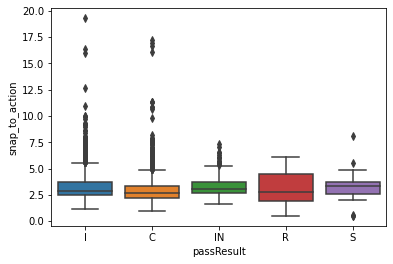

In [8]:
box = sns.boxplot(data=snap_to_action_df, x="passResult", y="snap_to_action")
plt.show()

In [9]:
snap_to_action_df[["playerName","snap_to_action"]].groupby("playerName").mean().sort_values(by=['snap_to_action'],ascending=[True]).reset_index().head()

,playerName,snap_to_action
0,Mitchell Trubisky,2.300000
1,Chad Henne,2.386667
2,Josh Rosen,2.500000
3,John Wolford,2.533333
4,Ben Roethlisberger,2.582222


In [10]:
snap_to_action_df[["passResult", "prePenaltyPlayResult", "snap_to_action"]].groupby("passResult")[["snap_to_action", "prePenaltyPlayResult"]].describe()

snap_to_action                                                    \
                    count      mean       std  min    25%  50%    75%   max   
passResult                                                                    
C                  4615.0  2.857985  1.019717  1.0  2.200  2.7  3.300  17.2   
I                  2760.0  3.254239  1.297508  1.2  2.500  2.9  3.700  19.3   
IN                  192.0  3.383854  1.069520  1.6  2.700  3.1  3.725   7.3   
R                    14.0  3.050000  1.720800  0.5  1.925  2.8  4.450   6.1   
S                    33.0  3.227273  1.391553  0.5  2.600  3.3  3.700   8.1   

           prePenaltyPlayResult                                              \
                          count       mean        std   min  25%  50%   75%   
passResult                                                                    
C                        4615.0  12.126327  10.343885  -8.0  6.0  9.0  15.0   
I                        2760.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
IN                        192.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
R                          14.0   9.428571   5.866650   2.0  5.5  8.0  10.0   
S                          33.0  -6.242424   4.272224 -14.0 -9.0 -5.0  -3.0   

                  
             max  
passResult        
C           91.0  
I            0.0  
IN           0.0  
R           22.0  
S            0.0

In [11]:
snap_to_action_df[["playerName", "passResult"]].groupby(["playerName","passResult"])["passResult"].count().reset_index(name="cnt").head()

,playerName,passResult,cnt
0,Aaron Rodgers,C,114
1,Aaron Rodgers,I,80
2,Aaron Rodgers,IN,3
3,Andy Dalton,C,33
4,Andy Dalton,I,12


### Rushers' Distance from QB at Release Analysis

In [12]:
# Get the distance of each of the 'rushers' from the QB on plays that the ball was released (no sacks, fumbles, runs, laterals, etc)

# 1. Get the time of the QB release on each play
coi = ['gameId', 'playId', 'frameId']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'autoevent_passinterrupted', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff']
potential_play_results = ['I', 'C', 'S', 'R', 'IN']
conds = f"position == 'QB' and event in {potential_action_events} and passResult in {potential_play_results}"
release_frame_df = gptp_df.query(conds)[coi].groupby(['gameId', 'playId']).max().reset_index()

# 2. Get the position of the QB at release on each play
coi = ['gameId', 'playId', 'frameId', 'x', 'y']
conds = "position == 'QB'"
qb_pos_df = gptp_df.query(conds)[coi]
qb_pos_at_rel_df = release_frame_df.merge(qb_pos_df, how='left', on=['gameId', 'playId', 'frameId']).rename(columns={"x":"qb_x_at_rel","y":"qb_y_at_rel"})
qb_pos_at_rel_df = qb_pos_at_rel_df.drop(columns=['frameId'])
qb_pos_at_rel_df.head()

# 3. Get the position of the "pass rushers" at release on each play
coi = ['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']
conds = "roleOnPlay == 'Pass Rush'"
rusher_pos_df = gptp_df.query(conds)[coi]
rusher_pos_df.head()
rusher_pos_at_rel_df = release_frame_df.merge(rusher_pos_df, how='left', on=['gameId', 'playId', 'frameId']).rename(columns={"x":"x_at_rel","y":"y_at_rel"})
rusher_pos_at_rel_df = rusher_pos_at_rel_df.drop(columns=['frameId'])
rusher_pos_at_rel_df.head()

# 4. Merge the rusher and qb pos dfs and get the rusher distance df
rusher_pos_at_rel_df = rusher_pos_at_rel_df.merge(qb_pos_at_rel_df, how='left', on=['gameId','playId'])
rusher_pos_at_rel_df['x2-x1'] = (rusher_pos_at_rel_df['qb_x_at_rel'] - rusher_pos_at_rel_df['x_at_rel'])**2
rusher_pos_at_rel_df['y2-y1'] = (rusher_pos_at_rel_df['qb_y_at_rel'] - rusher_pos_at_rel_df['y_at_rel'])**2
rusher_pos_at_rel_df['distance_at_rel'] = np.sqrt(rusher_pos_at_rel_df['x2-x1'] + rusher_pos_at_rel_df['y2-y1'])
rusher_dist_at_rel_df = rusher_pos_at_rel_df[['gameId','playId','nflId','distance_at_rel']]
rusher_dist_at_rel_df.head()

# 5. Join with the main play results df for analysis
rusher_dist_at_rel_df = rusher_dist_at_rel_df.merge(player_result_df, how='left', on=['gameId','playId','nflId'])

# 6. Join with the snap to action df
df_to_merge = snap_to_action_df[['gameId','playId','snap_to_action']]
rusher_dist_at_rel_df = rusher_dist_at_rel_df.merge(df_to_merge, how='left', on=['gameId','playId'])

# 7. Reorder the columns for viewing
columns = ['gameId', 'playId', 'nflId', 'season', 'week',
    'offTeam', 'defTeam', 'quarter', 'down', 'yardsToGo', 'passResult',
    'prePenaltyPlayResult', 'playerName', 'position', 'snap_to_action',
    'distance_at_rel']
rusher_dist_at_rel_df = rusher_dist_at_rel_df[columns]

rusher_dist_at_rel_df.head()



,gameId,playId,nflId,season,week,offTeam,defTeam,quarter,down,yardsToGo,passResult,prePenaltyPlayResult,playerName,position,snap_to_action,distance_at_rel
0,2021090900,97,41263.0,2021.0,1.0,TB,DAL,1.0,3.0,2.0,I,0.0,Demarcus Lawrence,DE,3.4,3.597777
1,2021090900,97,42403.0,2021.0,1.0,TB,DAL,1.0,3.0,2.0,I,0.0,Randy Gregory,DE,3.4,4.327863
2,2021090900,97,44955.0,2021.0,1.0,TB,DAL,1.0,3.0,2.0,I,0.0,Carlos Watkins,DE,3.4,11.325251
3,2021090900,97,53441.0,2021.0,1.0,TB,DAL,1.0,3.0,2.0,I,0.0,Micah Parsons,OLB,3.4,2.450796
4,2021090900,97,53504.0,2021.0,1.0,TB,DAL,1.0,3.0,2.0,I,0.0,Osa Odighizuwa,DT,3.4,1.785077


In [13]:
# Analyze individual pass rushers
common_rushers = rusher_dist_at_rel_df.playerName.value_counts().loc[lambda c: c > 50].index.tolist()
d_line = ['DE','DT','NT','OLB']
common_rushers_dist_at_rel_df = rusher_dist_at_rel_df[['position','playerName','distance_at_rel', 'snap_to_action']].query(f"(playerName in {common_rushers}) and (position in {d_line})")
avg_dist_at_rel_df = common_rushers_dist_at_rel_df.groupby(['position','playerName']).mean()
avg_dist_at_rel_df = avg_dist_at_rel_df.sort_values(by=['snap_to_action'],ascending=[True]).reset_index()
avg_dist_at_rel_df.head(5)

,position,playerName,distance_at_rel,snap_to_action
0,DT,Marlon Davidson,5.119209,2.644681
1,NT,Johnathan Hankins,5.707994,2.751852
2,DE,Isaiah Buggs,5.155574,2.761224
3,DT,Hassan Ridgeway,5.470819,2.761644
4,DE,Derek Barnett,4.285935,2.765248
